In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import json

In [2]:
output_folder = "tmp_output"
scenarios = next(os.walk(output_folder))[1]

,App coverage,R,Tests Needed
0,0.1000,0.8750,0.45
1,0.2125,1.0000,0.51
2,0.3250,1.0625,0.56
3,0.4375,1.0000,0.70
4,0.5500,0.7500,0.64
5,0.6625,0.8125,0.65
6,0.7750,0.9375,0.73
7,0.8875,1.0000,0.79
8,1.0000,0.9375,0.82


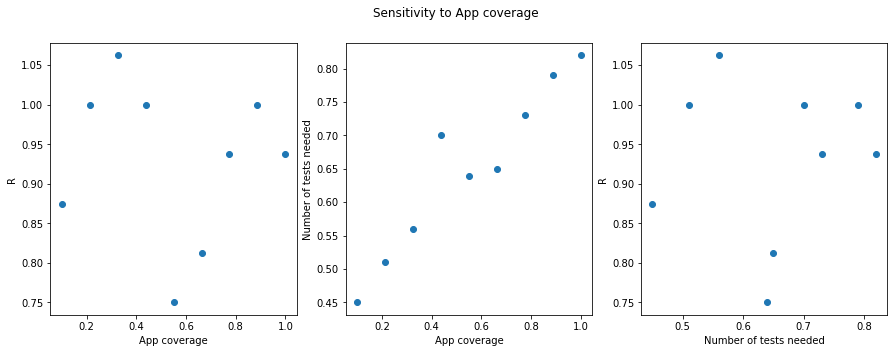

In [3]:
def get_param_data(param, scenario, output_folder):
    scenarios = next(os.walk(output_folder))[1]
    config_count = len(glob.glob(f'{output_folder}/{scenario}/*.json'))
    
    df_list = []

    for i in range(config_count):
        config_path = f'{output_folder}/{scenario}/config_{i}.json'
        run_path = f'{output_folder}/{scenario}/run_{i}.csv'

        with open(config_path) as config_file:
            run_config = json.load(config_file)

        if run_config['sensitivity_target'] == param:
            df = pd.read_csv(run_path, index_col=None, header=0)
            df['Strategy'] = scenario
            df[param] = run_config['config'][param]
            df_list.append(df)

    return pd.concat(df_list, axis=0, ignore_index=True)



def plots_for_param(param, df, param_label=None, plot_pareto=False, save_as=None):
    if param_label is None:
        param_label = param
    
    if plot_pareto:
        plot_count = 3
    else:
        plot_count = 2
    
    fig = plt.figure(figsize=(15, 5))

    plt.subplot(1, plot_count, 1)
    plt.scatter(df[param], df['Reduced R']);
    plt.xlabel(param_label);
    plt.ylabel('R');

    plt.subplot(1, plot_count, 2)
    plt.scatter(df[param], df['Tests Needed']);
    plt.xlabel(param_label);
    plt.ylabel('Number of tests needed');

    if plot_pareto:
        plt.subplot(1, plot_count, 3)
        plt.scatter(df['Tests Needed'], df['Reduced R']);
        plt.xlabel('Number of tests needed');
        plt.ylabel('R');
    
    plt.suptitle(f'Sensitivity to {param_label}')
    
    if save_as is not None:
        plt.savefig(save_as)

def table_for_param(param, df, param_label=None, as_latex=True):
    df = df[[param, 'Reduced R', 'Tests Needed']]
    
    if param_label is None:
        param_label = param
    
    df = df.rename(columns={param: param_label, 'Reduced R': 'R'})
    
    if as_latex:
        return df.to_latex()
    else:
        return df

# example usage
df = get_param_data("app_cov", "L4", "tmp_output")
plots_for_param("app_cov", df, param_label="App coverage", plot_pareto=True, save_as=None)
table_for_param("app_cov", df, param_label="App coverage", as_latex=False)

In [4]:
parameters = [
    {'name': 'testing_delay', 'label': 'Time needed to get test result',
     'show_plot': True, 'show_table': False,
     'plot_pareto': True, 'save_as': None},
    {'name': 'manual_trace_time', 'label': 'Time needed to trace contacts without an app',
     'show_plot': True, 'show_table': False,
     'plot_pareto': True, 'save_as': None},
    {'name': 'app_cov', 'label': 'App uptake',
     'show_plot': False, 'show_table': True,
     'as_latex': False},
    {'name': 'trace_adherence', 'label': 'Policy adherence to quarantine on being traced as a contact',
     'show_plot': False, 'show_table': True,
     'as_latex': False}
]

   App uptake         R  Tests Needed
0      0.1000  0.849031          0.44
1      0.2125  0.890970          0.51
2      0.3250  1.127935          0.50
3      0.4375  0.946015          0.65
4      0.5500  0.871176          0.70
5      0.6625  0.862954          0.65
6      0.7750  0.549218          0.73
7      0.8875  0.586985          0.80
8      1.0000  0.636799          0.82
   Policy adherence to quarantine on being traced as a contact         R  \
0                                                0.5            0.850560   
1                                                0.7            0.790703   
2                                                0.9            0.691076   

   Tests Needed  
0          0.56  
1          0.56  
2          0.56  


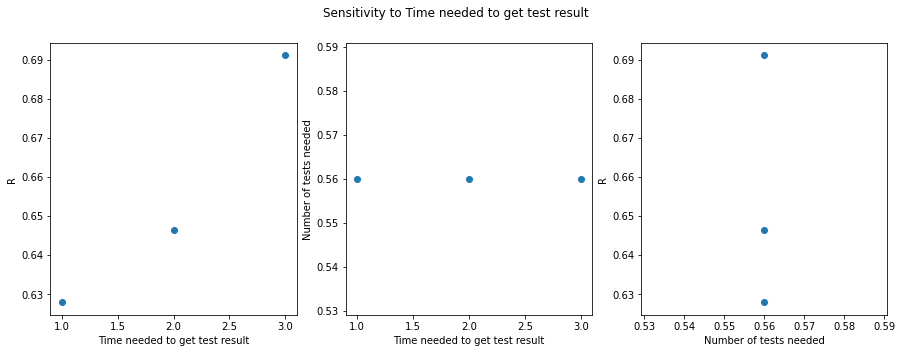

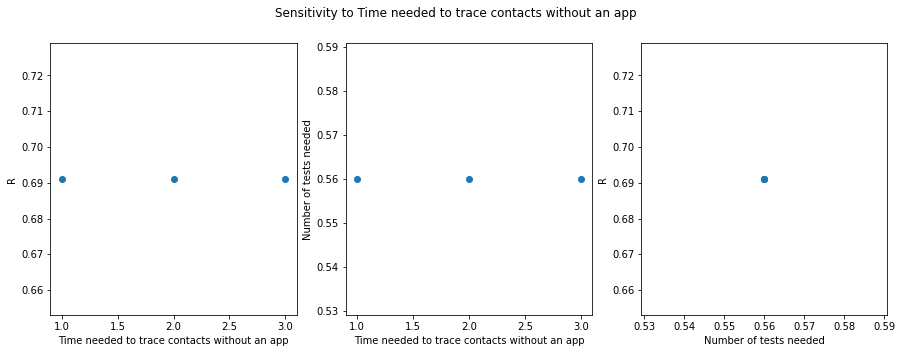

In [8]:
scenarios_to_plot = [scenarios[2]]

for param in parameters:
    for scenario in scenarios_to_plot:
        df = get_param_data(param['name'], scenario, output_folder)
        if param['show_plot']:
            plots_for_param(param['name'], df, param_label=param['label'],
                            plot_pareto=param['plot_pareto'], save_as=param['save_as'])
        
        if param['show_table']:
            print(table_for_param(param['name'], df, param_label=param['label'], as_latex=param['as_latex']))